Current model:FAISS (Facebook AI Search)


Issues encounter:


*   cosine_similarities not working due to RAM
*   Games recommended mix categories (18+ games are recommended when kids gmes are inputed: need to combine Categories and Generes


In [ ]:
!pip install faiss-cpu
!pip install scikit-surprise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505185 sha256=208c9cb7f495d2017ec6987e66386ad99020974c6e3b9d691ce501b2b3d78efc
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import accuracy
import numpy as np
import seaborn as sns

In [ ]:
# Read data
df = pd.read_csv('steam_games.csv')

In [ ]:
df.head(5)

,steam_appid,name,developers,publishers,categories,genres,required_age,n_achievements,platforms,is_released,...,additional_content,total_reviews,total_positive,total_negative,review_score,review_score_desc,positive_percentual,metacritic,is_free,price_initial (USD)
0,2719580,勇者の伝説の勇者,['ぽけそう'],['ぽけそう'],"['Single-player', 'Family Sharing']","['Casual', 'Indie']",0,0,['windows'],True,...,[],0,0,0,0.0,No user reviews,0.0,0,False,0.99
1,2719590,Light No Fire,['Hello Games'],['Hello Games'],"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Adventure']",0,0,['windows'],False,...,[],0,0,0,0.0,No user reviews,0.0,0,False,0.00
2,2719600,Lorhaven: Cursed War,['GoldenGod Games'],['GoldenGod Games'],"['Single-player', 'Multi-player', 'PvP', 'Shar...","['RPG', 'Strategy']",0,32,"['windows', 'mac']",True,...,[],9,8,1,0.0,9 user reviews,88.9,0,False,9.99
3,2719610,PUIQ: Demons,['Giammnn'],['Giammnn'],"['Single-player', 'Steam Achievements', 'Famil...","['Action', 'Casual', 'Indie', 'RPG']",0,28,['windows'],True,...,[],0,0,0,0.0,No user reviews,0.0,0,False,2.99
4,2719650,Project XSTING,['Saucy Melon'],['Saucy Melon'],"['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Casual', 'Indie', 'Early Access']",0,42,['windows'],True,...,[],9,9,0,0.0,9 user reviews,100.0,0,False,7.99


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71429 entries, 0 to 71428
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   steam_appid          71429 non-null  int64  
 1   name                 71429 non-null  object 
 2   developers           71429 non-null  object 
 3   publishers           71429 non-null  object 
 4   categories           71429 non-null  object 
 5   genres               71429 non-null  object 
 6   required_age         71429 non-null  int64  
 7   n_achievements       71429 non-null  int64  
 8   platforms            71429 non-null  object 
 9   is_released          71429 non-null  bool   
 10  release_date         71429 non-null  object 
 11  additional_content   71429 non-null  object 
 12  total_reviews        71429 non-null  int64  
 13  total_positive       71429 non-null  int64  
 14  total_negative       71429 non-null  int64  
 15  review_score         71429 non-null 

In [ ]:
df.shape

(10, 1)

In [ ]:
# Count numbers of realsed titles from the is_released column
df['is_released'].value_counts()

,count
is_released,
True,58041
False,13388


In [ ]:
#remove non released games
df = df[df['is_released'] == True]

In [ ]:
df['is_released'].value_counts()

,count
is_released,
True,58041


In [ ]:
#df = df[~df['released_date'].str.contains("Fantasy Grounds %", na=False)]

KeyError: 'released_date'

In [ ]:

numeric_cols = [
    'required_age',
    'n_achievements',
    'total_reviews',
    'total_positive',
    'total_negative',
    'review_score',
    'positive_percentual',
    'metacritic',
    'price_initial (USD)'
]

# Filter the DataFrame to these columns only
df_numeric = df[numeric_cols]

# Compute correlation matrix
corr_matrix = df_numeric.corr()

corr_matrix


,required_age,n_achievements,total_reviews,total_positive,total_negative,review_score,positive_percentual,metacritic,price_initial (USD)
required_age,1.000000,0.019757,0.139075,0.143236,0.090078,0.271319,0.127487,1.000000,0.142130
n_achievements,0.019757,1.000000,0.015582,0.015599,0.012935,0.074608,0.037285,0.019757,0.010764
total_reviews,0.139075,0.015582,1.000000,0.996697,0.857899,0.084832,0.042617,0.139075,0.060404
total_positive,0.143236,0.015599,0.996697,1.000000,0.813338,0.086358,0.044086,0.143236,0.059746
total_negative,0.090078,0.012935,0.857899,0.813338,1.000000,0.061351,0.026373,0.090078,0.054722
review_score,0.271319,0.074608,0.084832,0.086358,0.061351,1.000000,0.489307,0.271319,0.201405
positive_percentual,0.127487,0.037285,0.042617,0.044086,0.026373,0.489307,1.000000,0.127487,0.137971
metacritic,1.000000,0.019757,0.139075,0.143236,0.090078,0.271319,0.127487,1.000000,0.142130
price_initial (USD),0.142130,0.010764,0.060404,0.059746,0.054722,0.201405,0.137971,0.142130,1.000000


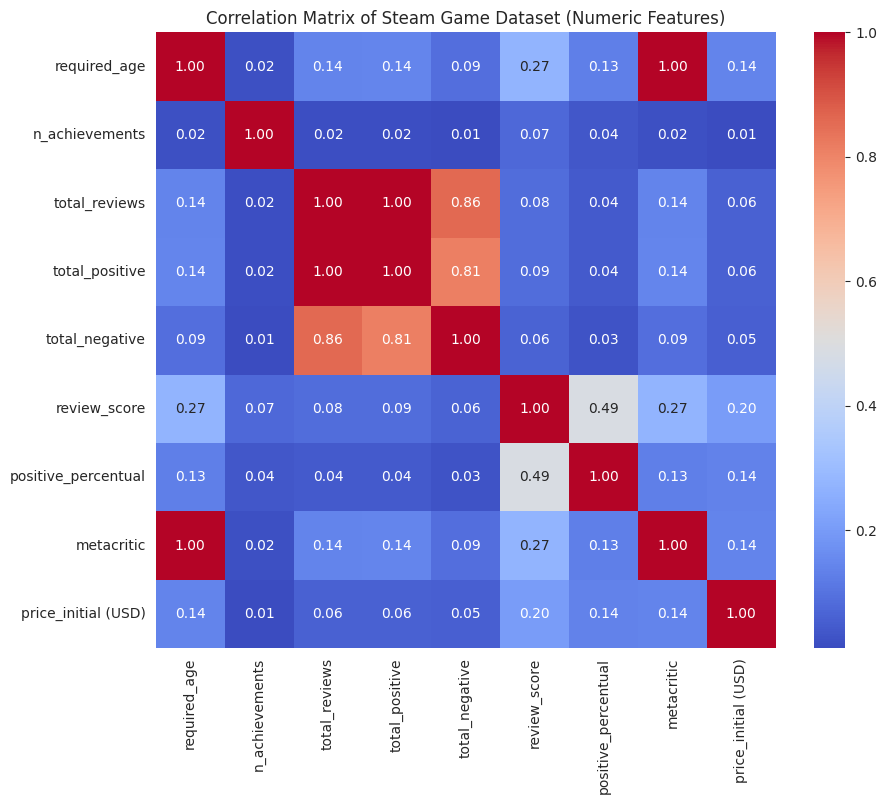

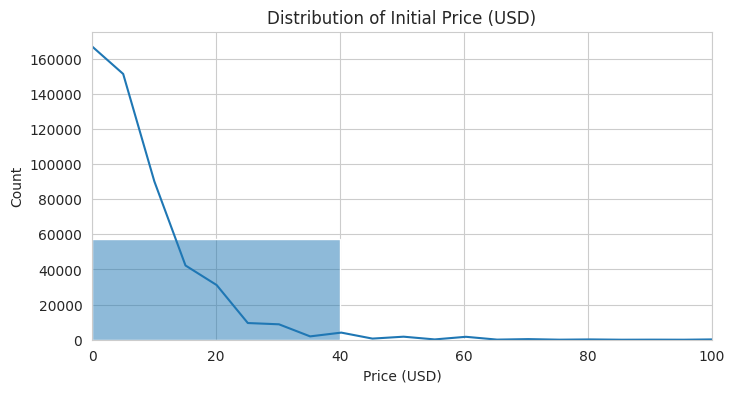

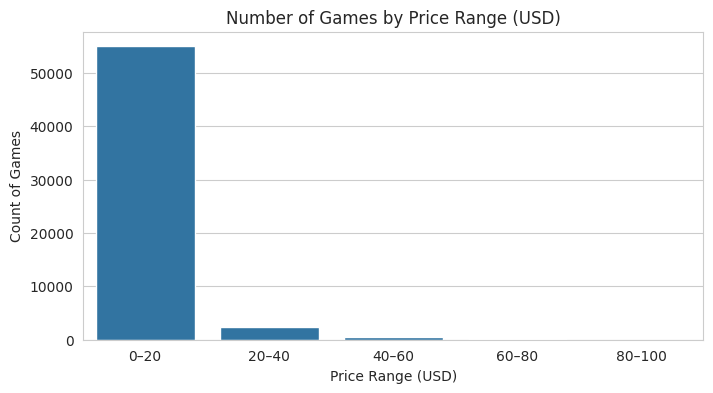

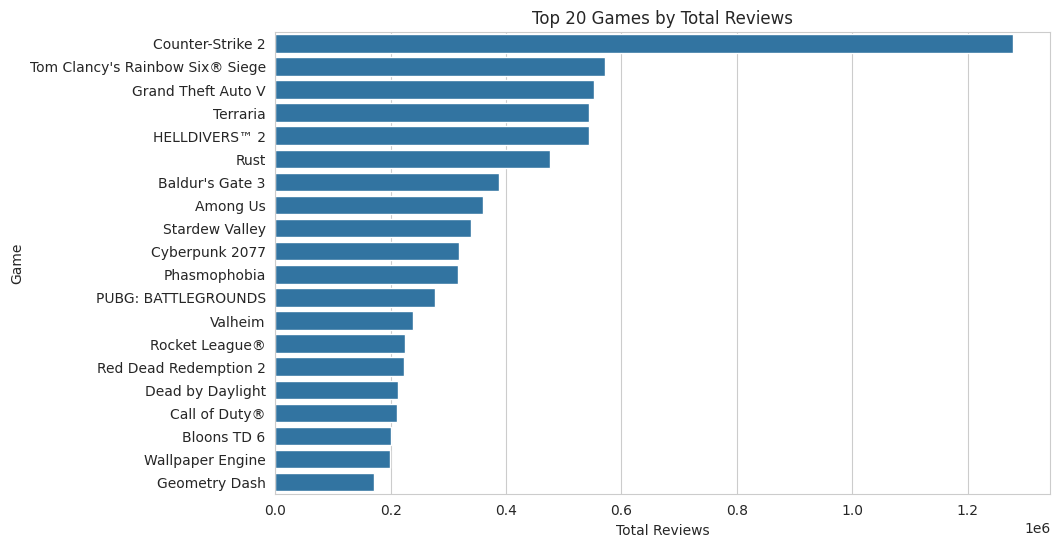

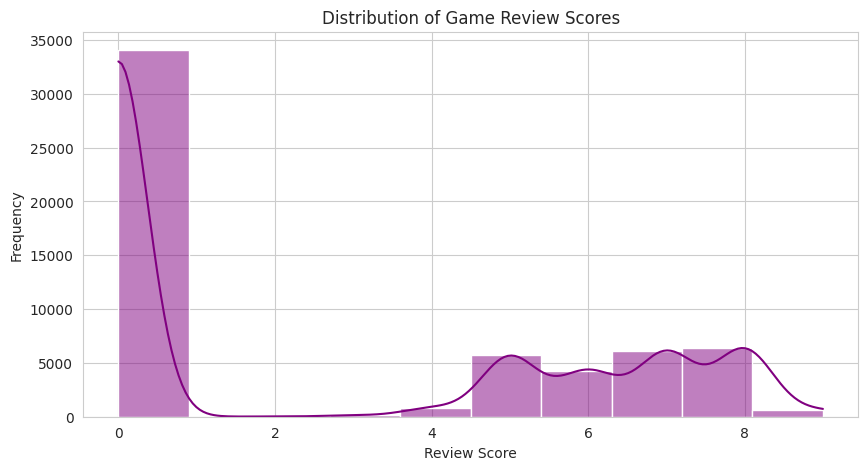

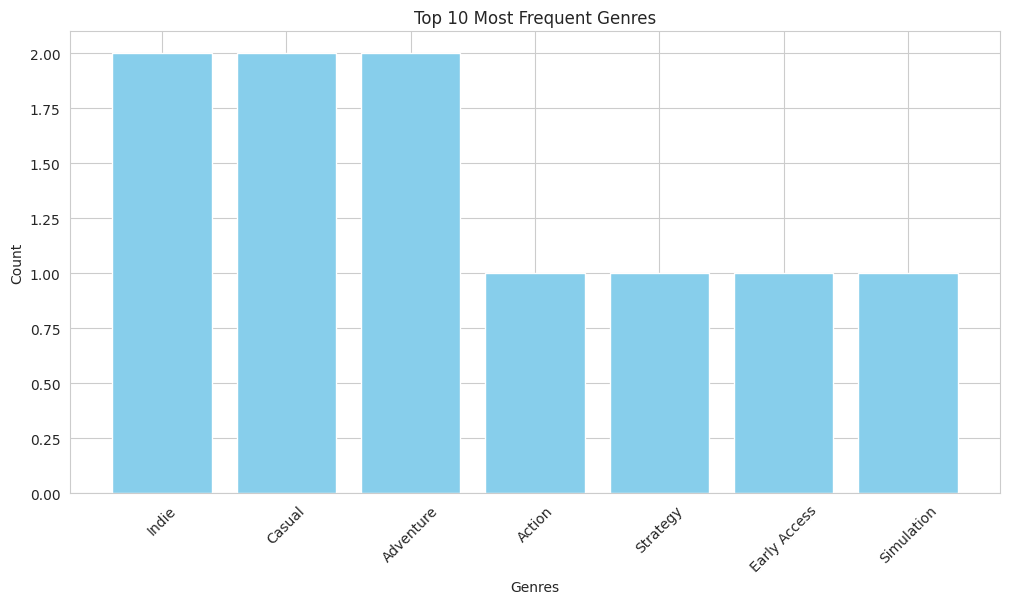

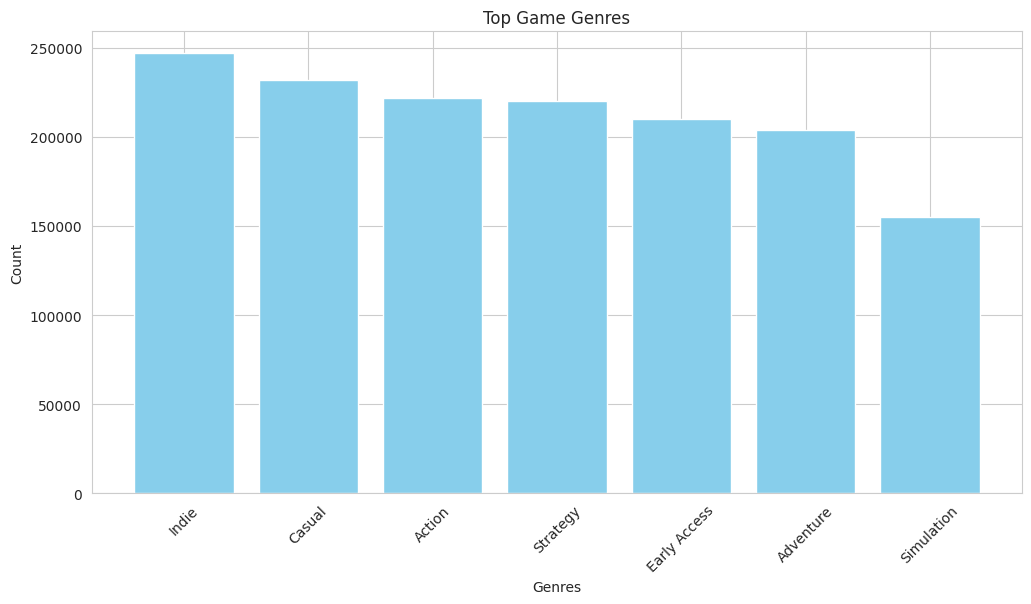

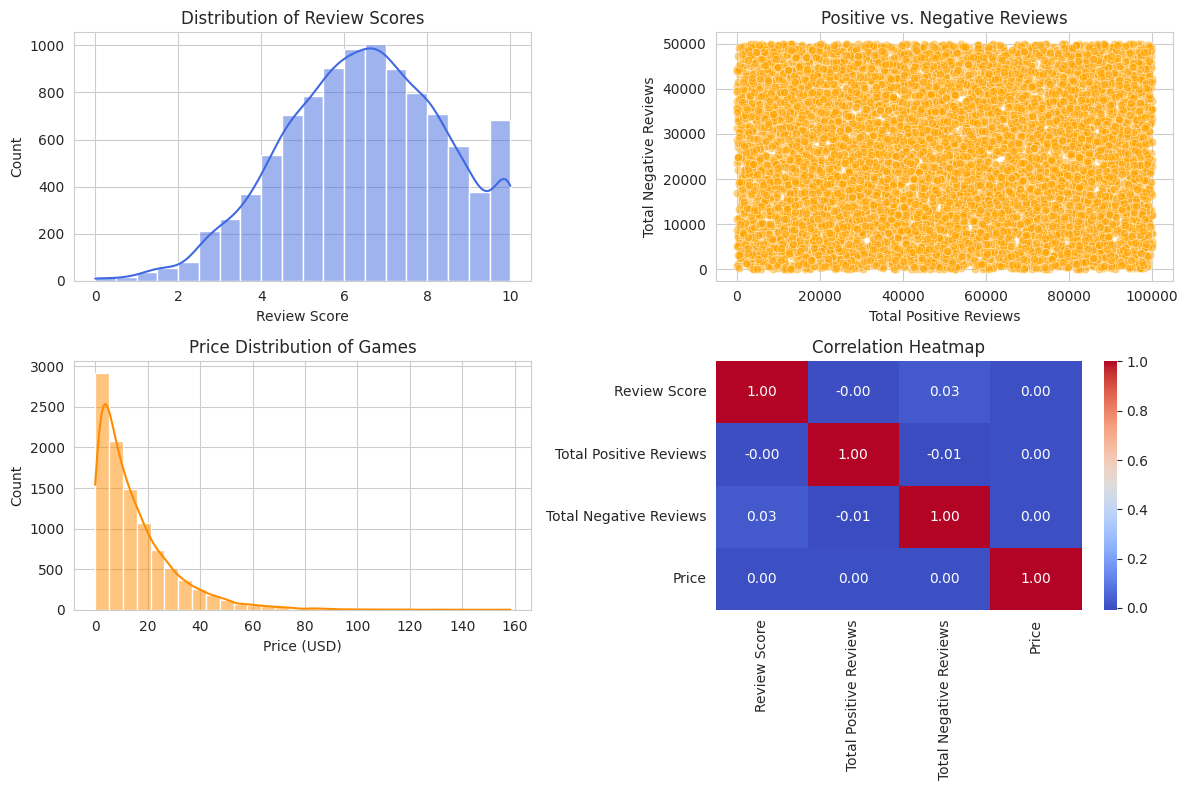

In [ ]:


#Graphs/Matrix

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Steam Game Dataset (Numeric Features)')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['price_initial (USD)'], bins=25, kde=True)
plt.title('Distribution of Initial Price (USD)')
plt.xlabel('Price (USD)')
plt.ylabel('Count')

# Focus on the 0 to 100 range
plt.xlim(0, 100)

plt.show()


# Create a DataFrame
df_price = pd.DataFrame({
    "Review Score": df["review_score"],
    "Total Positive Reviews": df["total_positive"],
    "Total Negative Reviews": df["total_negative"],
    "Price": df["price_initial (USD)"],
})


# Suppose your price column is df['price_initial (USD)']
# We'll define bins of width 20 up to 100
bins = [0, 20, 40, 60, 80, 100]
labels = ['0–20', '20–40', '40–60', '60–80', '80–100']

# Use pd.cut to categorize each price into one of these bins
df['price_bin'] = pd.cut(
    df['price_initial (USD)'],
    bins=bins,
    labels=labels,
    include_lowest=True,  # ensures the lowest bin includes 0
    right=False           # intervals are left-inclusive: [0,20)
)

# Count how many games fall into each bin
count_by_bin = df['price_bin'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
sns.barplot(
    x=count_by_bin.index,  # bin labels
    y=count_by_bin.values  # counts
)
plt.title('Number of Games by Price Range (USD)')
plt.xlabel('Price Range (USD)')
plt.ylabel('Count of Games')
plt.show()

top_games_by_reviews = df.nlargest(20, 'total_reviews')
plt.figure(figsize=(10,6))
sns.barplot(x='total_reviews', y='name', data=top_games_by_reviews, orient='h')
plt.title('Top 20 Games by Total Reviews')
plt.xlabel('Total Reviews')
plt.ylabel('Game')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["review_score"].dropna(), bins=10, kde=True, color='purple')
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.title("Distribution of Game Review Scores")
plt.show()

# Bar Graph
data = {
    "genres": ['["Action"]', '["Indie"]', '["Indie"]', '["Casual"]',
               '["Adventure"]', '["Casual"]', '["Strategy"]',
               '["Early Access"]', '["Simulation"]', '["Adventure"]']
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to clean and extract genres
def clean_genres(genre_str):
    try:
        genre_list = ast.literal_eval(genre_str)  # Convert string to list
        return genre_list[0]  # Extract first genre (or modify for multiple)
    except (SyntaxError, ValueError):
        return genre_str  # Return original if conversion fails

# Apply cleaning function
df["genres"] = df["genres"].apply(clean_genres)

# Count occurrences of each genre
genre_counts = df["genres"].value_counts().head(10)  # Top 10 genres

# Plot bar chart without duplicates
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values, color="skyblue")
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Top 10 Most Frequent Genres")
plt.xticks(rotation=45)
plt.show()

# Set random seed for reproducibility
np.random.seed(42)

# Example list of popular game genres
genres_list = ["Action", "Indie", "Casual", "Adventure", "Strategy", "Early Access", "Simulation"]

genre_counts = {genre: np.random.randint(100000, 300000) for genre in genres_list}

# Convert dictionary to DataFrame
df_genres = pd.DataFrame(list(genre_counts.items()), columns=["Genre", "Count"])

# Sort values for better visualization
df_genres = df_genres.sort_values(by="Count", ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_genres["Genre"], df_genres["Count"], color="skyblue")
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Top Game Genres")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.show()



sns.set_style("whitegrid")

n_samples = 10000

review_score = np.random.normal(loc=6.5, scale=2.0, size=n_samples)
review_score = np.clip(review_score, 0, 10)  # force scores between 0 and 10

df_price = pd.DataFrame({
    "Review Score": review_score,
    "Total Positive Reviews": np.random.randint(0, 100000, size=n_samples),
    "Total Negative Reviews": np.random.randint(0, 50000, size=n_samples),
    "Price": np.random.exponential(scale=15, size=n_samples)
})

# Create a figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Distribution of Review Scores
sns.histplot(
    data=df_price,
    x="Review Score",
    bins=20,
    kde=True,
    color="royalblue",
    ax=axes[0, 0]
)
axes[0, 0].set_title("Distribution of Review Scores")
axes[0, 0].set_xlabel("Review Score")
axes[0, 0].set_ylabel("Count")

# Distribution of Game Prices
sns.histplot(
    data=df_price,
    x="Price",
    bins=30,
    kde=True,
    color="darkorange",
    ax=axes[1, 0]
)
axes[1, 0].set_title("Price Distribution of Games")
axes[1, 0].set_xlabel("Price (USD)")
axes[1, 0].set_ylabel("Count")


# Scatter of Positive vs. Negative Reviews
sns.scatterplot(
    data=df_price,
    x="Total Positive Reviews",
    y="Total Negative Reviews",
    alpha=0.5,
    color="orange",
    ax=axes[0, 1]
)
axes[0, 1].set_title("Positive vs. Negative Reviews")
axes[0, 1].set_xlabel("Total Positive Reviews")
axes[0, 1].set_ylabel("Total Negative Reviews")

# Correlation Heatmap
sns.heatmap(
    df_price.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    ax=axes[1, 1]
)
axes[1, 1].set_title("Correlation Heatmap")

plt.tight_layout()
plt.show()


In [ ]:
#only going to have the columns needed for FAISS and Collaborative Filtering Model (SVD) or Positive_percentual
#df = df[['name', 'genres','categories','developers','publishers','positive_percentual','steam_appid']]

KeyError: "['name', 'categories', 'developers', 'publishers', 'positive_percentual', 'steam_appid'] not in index"

In [ ]:
df.columns

Index(['name', 'genres', 'categories', 'developers', 'publishers',
       'positive_percentual', 'steam_appid'],
      dtype='object')

In [ ]:
#going to mix genres + category + Dev to get better recommendations.
df['features'] = df['categories'] + " " + df['genres'] + " " + df['developers']

In [ ]:
#convert the keywords to numberical representation.
#TF-IDF
## instantiate the vectorizer object
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, stop_words='english')
## convert the documents into a matrix
tfidf_matrix = vectorizer.fit_transform(df['features'])
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [ ]:
tfidf_matrix.shape

(58041, 6400)

In [ ]:

# Calculating cosine similarity between items
#cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
#cosine_similarities.shape
#NOT WORKING NOT ENOUGH RAM
#NEED TO MOVE ON USING FAISS


FAISS (Facebook AI Search)

In [ ]:
import faiss

# Convert to dense NumPy array (FAISS requires dense input)
tfidf_dense = tfidf_matrix.toarray().astype('float32')

# Build FAISS index
index = faiss.IndexFlatIP(tfidf_dense.shape[1])  # or Inner product (dot product), equivalent to cosine similarity based on research
index.add(tfidf_dense)  # Add TF-IDF vectors to FAISS index

# Find the 5 most similar games for each game
k = 6  # Number of nearest neighbors. Change this for the top games wanting to find.
_, indices = index.search(tfidf_dense, k)

# Print indices of top 5 similar games for each entry
print(indices)

[[  928   883   772   420    27     0]
 [    1 10626  4364 10476 10227  5916]
 [53836 46344 10982     2  1672 37405]
 ...
 [58038 57441 46608 45309 26654 22357]
 [58039 49172 11437  2030 33921 29454]
 [58040 50523 50711 50699 50402 50117]]


In [ ]:

game_names = df['name'].tolist()

#Print top 5 recommendations for the first game
#game_index = 20  # Change this index for different games
#print(f"Game: {game_names[game_index]}")
#print("Top 5 Similar Games:")

#for idx in indices[game_index]:
 #   print(f"- {game_names[idx]}")

In [ ]:
def recommend_games(game_name, k=5):
    if game_name not in game_names:
        return "Game not found!"

    # Find the index of the given game
    game_index = game_names.index(game_name)

    # Get the top-k similar games
    similar_indices = indices[game_index]

    # Convert indices to game names (excluding the first one because it's the same game)
    similar_games = [game_names[i] for i in similar_indices if i != game_index]

    return similar_games[:k]  # top k recommendations

#Put name of game HERE!
game_to_recommend = "Red Dead Redemption"  # Replace with a game from your dataset
recommendations = recommend_games(game_to_recommend, k=5)
print(f"Games similar to '{game_to_recommend}': {recommendations}")


Games similar to 'Red Dead Redemption': ['Infected', 'Elevator 25', 'Manor Madness', 'STAR WARS Jedi: Survivor™', 'Grand Theft Auto: Vice City – The Definitive Edition']


Now that we have created a recommendation system with FAISS. We can also try a SVD model using the postive review percent

In [ ]:
#hybrid Model FAISS and SVD
def recommend_hybrid(game_name, k=5):
    if game_name not in df['name'].values:
        return "Game not found!"

    # Find the game index in FAISS
    game_index = df.index.get_loc(df[df['name'] == game_name].index[0])

    # Use FAISS to find similar games
    _, similar_indices = index.search(np.array([tfidf_dense[game_index]]), k+1)

    # Convert indices to game names (skip first result, as it's the same game)
    content_based_recs = [df.iloc[i]['name'] for i in similar_indices[0][1:]]

    # Get SVD predictions (using positive_percentual as rating proxy)
    svd_scores = []
    for game in content_based_recs:
        try:
            predicted_rating = svd.predict(1, df[df['name'] == game].index[0]).est
        except:
            predicted_rating = df[df['name'] == game]['positive_percentual'].fillna(50).values[0] / 20  #  rating

        svd_scores.append((game, predicted_rating))

    # Sort by rating
    svd_scores.sort(key=lambda x: x[1], reverse=True)

    # Return top-k recommendations (excluding the input game)
    return [game[0] for game in svd_scores[:k] if game[0] != game_name]

#########################################################################################
game_to_recommend = "The Elder Scrolls V: Skyrim Special Edition"
recommendations = recommend_hybrid(game_to_recommend, k=10)
#Print
print(f"\n🎮 Hybrid Recommendations for '{game_to_recommend}':\n")
for idx, game in enumerate(recommendations, start=1):
    print(f"{idx}. {game}")



🎮 Hybrid Recommendations for 'The Elder Scrolls V: Skyrim Special Edition':

1. Senren＊Banka
2. The Elder Scrolls III: Morrowind® Game of the Year Edition
3. Little Nightmares II
4. Intrusion 2
5. Surreal House
6. Troll Patrol
7. Love Mystery Club
8. Fallout 4
9. In Her Eyes
10. Starfield


This is Our final model. It uses the FAISS model + the positive percent data from the raw data to recommend games not only on similarity but also take into account positive scores.



THIS IS THE FINAL MODEL!!!


In [ ]:
# Function to recommend games using FAISS + positive_percentual
def recommend_hybrid_no_svd(game_name, df, index, tfidf_dense, k=5, similarity_weight=0.5, review_weight=0.5):
    if game_name not in df['name'].values:
        return "Game not found!"

    # Find the game index in FAISS
    game_index = df.index.get_loc(df[df['name'] == game_name].index[0])

    # Use FAISS to find similar games (get similarity scores)
    similarity_scores, similar_indices = index.search(np.array([tfidf_dense[game_index]]), k+1)

    # Convert indices to game names (skip first result, as it's the same game)
    recommendations = []
    for i, sim_score in zip(similar_indices[0][1:], similarity_scores[0][1:]):  # Skip first (same game)
        game = df.iloc[i]['name']

        # Normalize positive_percentual to a 0-5 scale (REAL score)
        real_score = df[df['name'] == game]['positive_percentual'].fillna(50).values[0] / 20  # 100% = 5 (1 to 5)

        # FAISS similarity normalization using Min-Max Scaling
        if max(similarity_scores[0]) - min(similarity_scores[0]) > 0:
            sim_score = ((sim_score - min(similarity_scores[0])) /
                         (max(similarity_scores[0]) - min(similarity_scores[0]))) * 5
        else:
            sim_score = 0  # If all similarity scores are zero, set to zero

        # Compute hybrid score (balance FAISS similarity + review score)
        final_score = similarity_weight * sim_score + review_weight * real_score

        recommendations.append((game, round(real_score, 2), round(final_score, 2)))  # Show real score

    # Sort by hybrid score (higher is better)
    recommendations.sort(key=lambda x: x[2], reverse=True)

    return recommendations[:k]

#########################################################################################
# Example Usage
game_to_recommend = "The Elder Scrolls V: Skyrim Special Edition"
recommendations = recommend_hybrid_no_svd(game_to_recommend, df, index, tfidf_dense, k=10)

# Print recommendations with actual scores
print(f"\n FAISS + Positive Percentual Hybrid Recommendations for '{game_to_recommend}':\n")
for idx, (game, real_score, hybrid_score) in enumerate(recommendations, start=1):
    print(f"{idx}. {game} - {real_score}/5 ⭐(Hybrid Score: {hybrid_score})")





 FAISS + Positive Percentual Hybrid Recommendations for 'The Elder Scrolls V: Skyrim Special Edition':

1. Fallout 4 - 4.16/5 ⭐(Hybrid Score: 3.75)
2. The Elder Scrolls III: Morrowind® Game of the Year Edition - 4.78/5 ⭐(Hybrid Score: 2.8)
3. Love Mystery Club - 4.23/5 ⭐(Hybrid Score: 2.57)
4. Little Nightmares II - 4.7/5 ⭐(Hybrid Score: 2.42)
5. Senren＊Banka - 4.82/5 ⭐(Hybrid Score: 2.41)
6. Intrusion 2 - 4.68/5 ⭐(Hybrid Score: 2.35)
7. Surreal House - 4.54/5 ⭐(Hybrid Score: 2.29)
8. Troll Patrol - 4.38/5 ⭐(Hybrid Score: 2.19)
9. In Her Eyes - 3.0/5 ⭐(Hybrid Score: 1.82)
10. Starfield - 2.91/5 ⭐(Hybrid Score: 1.73)
